## Cluster Validation

One of the big issues with clustering methods is that they will return clusters even if the data does not contain any clusters. Thus its important to assess clustering tendency before the analysis and also validate the quality of the results after clustering.

In general clustering validation statistics can be grouped into following 4 classes. 

Relative clustering validation: This evaluates the clustering structure by varying different parameter values for the same algorithm (e.g.,: varying the number of clusters k). It’s generally used for determining the optimal number of clusters.

External clustering validation: This method compares the results of a cluster analysis to an externally known result, such as externally provided class labels. Since we know the “true” cluster number in advance, this approach is mainly used for selecting the right clustering algorithm for a specific dataset.

Internal clustering validation: This method uses internal information of the clustering process to evaluate the goodness of a clustering structure without reference to external information. It can be also used for estimating the number of clusters and the appropriate clustering algorithm without any external data.

Clustering stability validation: This method is a special version of internal validation. It evaluates the consistency of a clustering result by comparing it with the clusters obtained after each column is removed, one at a time.

We will be using following lis of packages for clusters evaluation

* **cluster: ** For analyzing cluster silhouettes
* **factoextra: ** For visualizing clusters using ggplot2 plotting system
* **NbClust: ** For determining the optimal number of clusters in the data
* **fpc: ** For computing clustering validation statistics

In [1]:
library(factoextra)
library(cluster)
library(fpc)
library(NbClust)

Loading required package: ggplot2


### Data Preparation

Load the Dow Jones Index dataset from /directory/dowjines/dow_jones_index.data file.

In [2]:
customers_data = read.csv("../../../datasets/wholesale/Wholesale_customers_data.csv",sep=',',header=TRUE)
head(customers_data)

Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
2,3,12669,9656,7561,214,2674,1338
2,3,7057,9810,9568,1762,3293,1776
2,3,6353,8808,7684,2405,3516,7844
1,3,13265,1196,4221,6404,507,1788
2,3,22615,5410,7198,3915,1777,5185
2,3,9413,8259,5126,666,1795,1451


### Determine the optimal number of clusters

The NbClust package will compute the optimal number of clusters for your data with a single function call.

In [3]:
customers_scaled = customers_data[,names(customers_data)!=('Region')]
table(customers_data$Region)
# attach(iris)
# iris_scaled = iris[,-5]


  1   2   3 
 77  47 316 

Warning message in pf(beale, pp, df2):
“NaNs produced”

*** : The Hubert index is a graphical method of determining the number of clusters.
                In the plot of Hubert index, we seek a significant knee that corresponds to a 
                significant increase of the value of the measure i.e the significant peak in Hubert
                index second differences plot. 
 


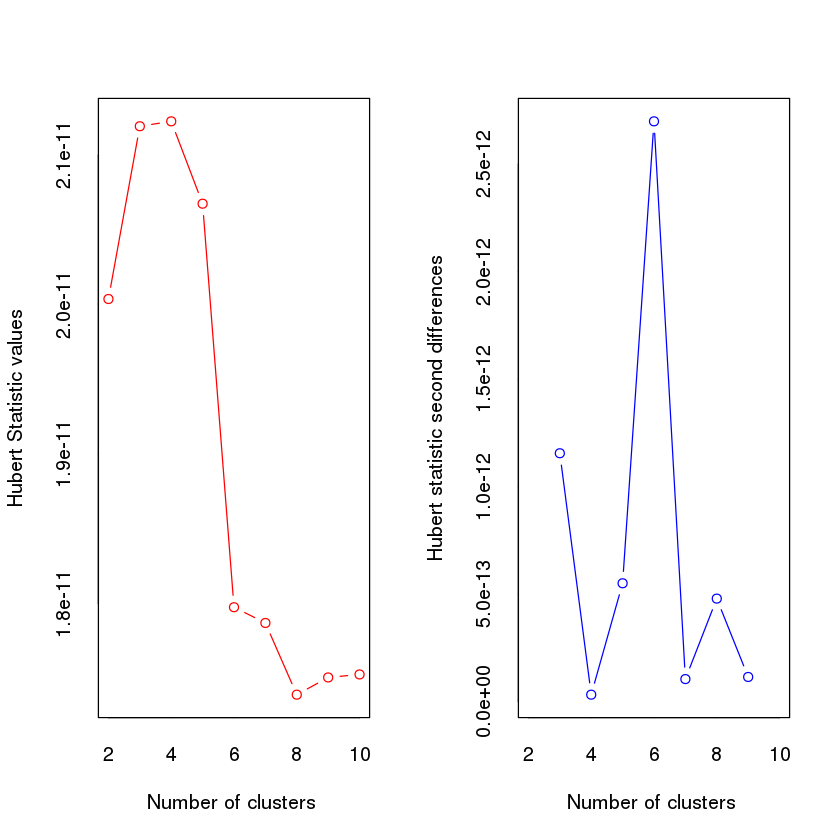

*** : The D index is a graphical method of determining the number of clusters. 
                In the plot of D index, we seek a significant knee (the significant peak in Dindex
                second differences plot) that corresponds to a significant increase of the value of
                the measure. 
 
******************************************************************* 
* Among all indices:                                                
* 6 proposed 2 as the best number of clusters 
* 3 proposed 3 as the best number of clusters 
* 1 proposed 4 as the best number of clusters 
* 3 proposed 5 as the best number of clusters 
* 3 proposed 6 as the best number of clusters 
* 1 proposed 7 as the best number of clusters 
* 5 proposed 8 as the best number of clusters 
* 2 proposed 10 as the best number of clusters 

                   ***** Conclusion *****                            
 
* According to the majority rule, the best number of clusters is  2 
 
 
****************************

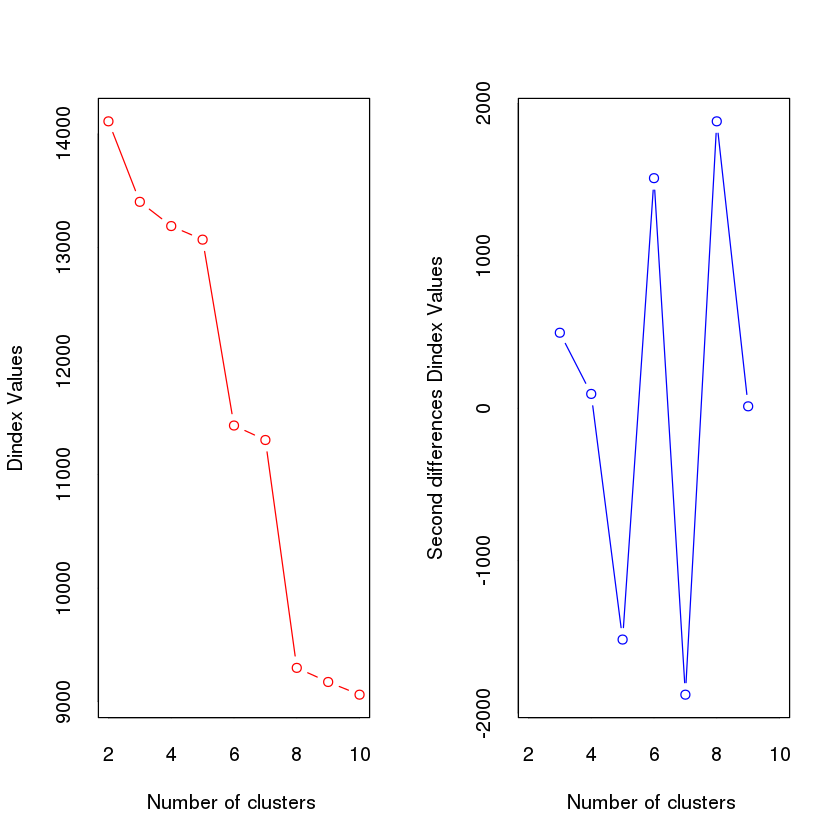

In [6]:
# Compute the number of clusters
library(NbClust)
nb <- NbClust(customers_scaled, distance = "euclidean", min.nc = 2,
        max.nc = 10, method = "complete", index ="all")

So NBclust is suggesting to form 2 clusters. 

Among all indices: 
* 2 proposed  0 as the best number of clusters
* 6 proposed  2 as the best number of clusters
* 3 proposed  3 as the best number of clusters
* 1 proposed  4 as the best number of clusters
* 3 proposed  5 as the best number of clusters
* 3 proposed  6 as the best number of clusters
* 1 proposed  7 as the best number of clusters
* 5 proposed  8 as the best number of clusters
* 2 proposed  10 as the best number of clusters

Conclusion
* According to the majority rule, the best number of clusters is  2 .



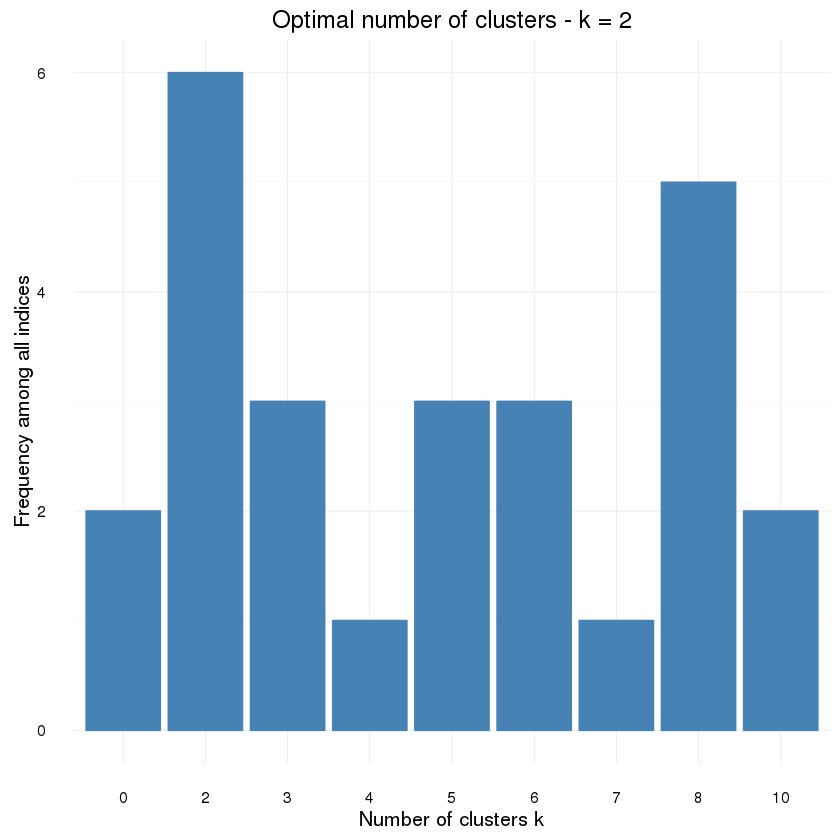

In [7]:
# Visualize the result
library(factoextra)
fviz_nbclust(nb) + theme_minimal()

### Clustering analysis

Use eclust() function in factoextra package. eclust() stands for enhanced clustering. It simplifies the workflow of clustering analysis.

In [8]:
# K-means clustering
km.res <- eclust(customers_scaled, "kmeans", k = 2,nstart = 25, graph = FALSE)
# k-means group number of each observation
table(km.res$cluster)


  1   2 
 65 375 

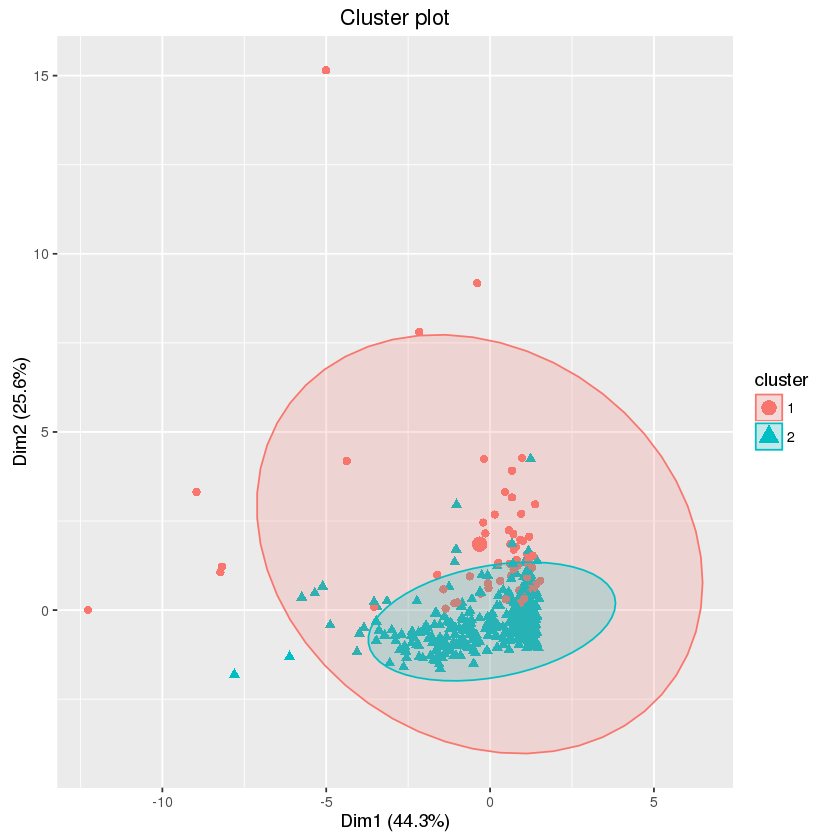

In [9]:
# Visualize k-means clusters
fviz_cluster(km.res, geom = "point", frame.type = "norm")

Repeat the kmeans clustering with K=3

In [10]:
# K-means clustering
km.res1 <- eclust(customers_scaled, "kmeans", k = 3,nstart = 25, graph = FALSE)
# k-means group number of each observation
table(km.res1$cluster)


  1   2   3 
 60  50 330 

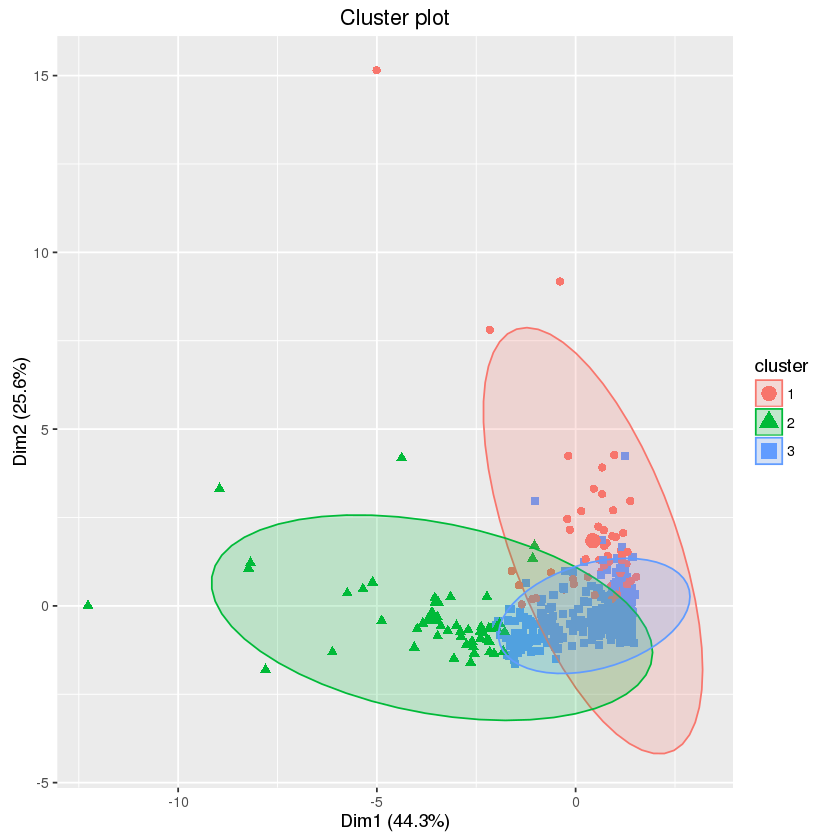

In [11]:
# Visualize k-means clusters
fviz_cluster(km.res1, geom = "point", frame.type = "norm")

### Hierarchical Clustering Results

In [12]:
# Enhanced hierarchical clustering
res.hc <- eclust(customers_scaled, "hclust", k = 3, method = "complete", graph = FALSE) 
table(res.hc$cluster)


  1   2   3 
261 134  45 

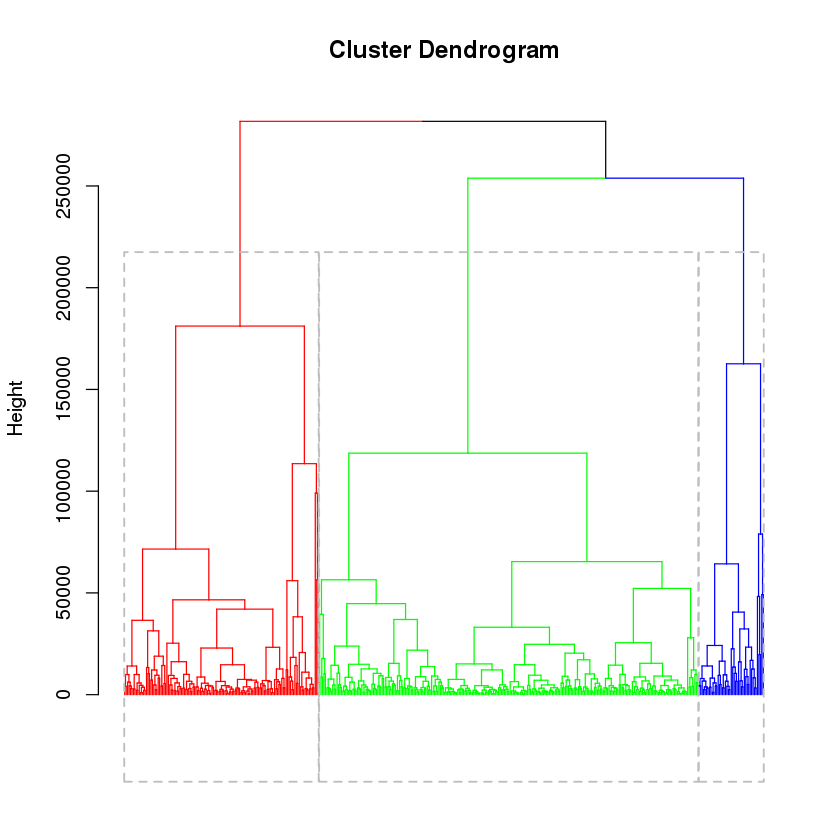

In [13]:
# Dendrogram
fviz_dend(res.hc, rect = TRUE, show_labels = FALSE)

### Internal clustering validation measures

The goal of clustering algorithms is to split the dataset into clusters of objects, such that:

* the objects in the same cluster are similar as much as possible,
* the objects in different clusters are highly distinct

i'e we want the average distance within cluster to be as small as possible; and the average distance between clusters to be as large as possible.

Following measures help us evaluate the clusters internally.

**Compactness: ** measures evaluate how close are the objects within the same cluster. A lower within-cluster variation is an indicator of a good compactness (i.e., a good clustering). The different indices for evaluating the compactness of clusters are base on distance measures such as the cluster-wise within average/median distances between observations.

**Separation: ** measures determine how well-separated a cluster is from other clusters. The indices used as separation measures include: distances between cluster centers the pairwise minimum distances between objects in different clusters

**Connectivity: ** corresponds to what extent items are placed in the same cluster as their nearest neighbors in the data space. The connectivity has a value between 0 and infinity and should be minimized

#### 1. Silhouette analysis

Silhouette analysis measures how well an observation is clustered and it estimates the average distance between clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters. The silhouette coefficient of observations can be computed using the function silhouette() in cluster package. 

$$silhouette(x, dist, ...)$$ where



_x_: an integer vector containing the cluster assignment of observations

_dist_: a dissimilarity object created by the function dist()

The function silhouette() returns an object, of class silhouette containing:

* The cluster number of each observation **i**
* The neighbor cluster of **i** (the cluster, not containing **i**, for which the average dissimilarity between its observations and **i** is minimal)
* The silhouette width $s_i$ of each observation


The R code below computes silhouette analysis and a plot is generated using R base plot:

In [14]:
# Silhouette coefficient of observations
library("cluster")
sil <- silhouette(km.res1$cluster, dist(customers_scaled))
head(sil[, 1:3], 10)

cluster,neighbor,sil_width
3,1,0.56791248
3,2,0.55066241
3,2,0.54858202
3,1,0.58728270
1,3,-0.10137649
3,1,0.66498960
3,1,0.64027161
3,2,0.63869077
3,2,0.70982235
2,3,-0.01008851


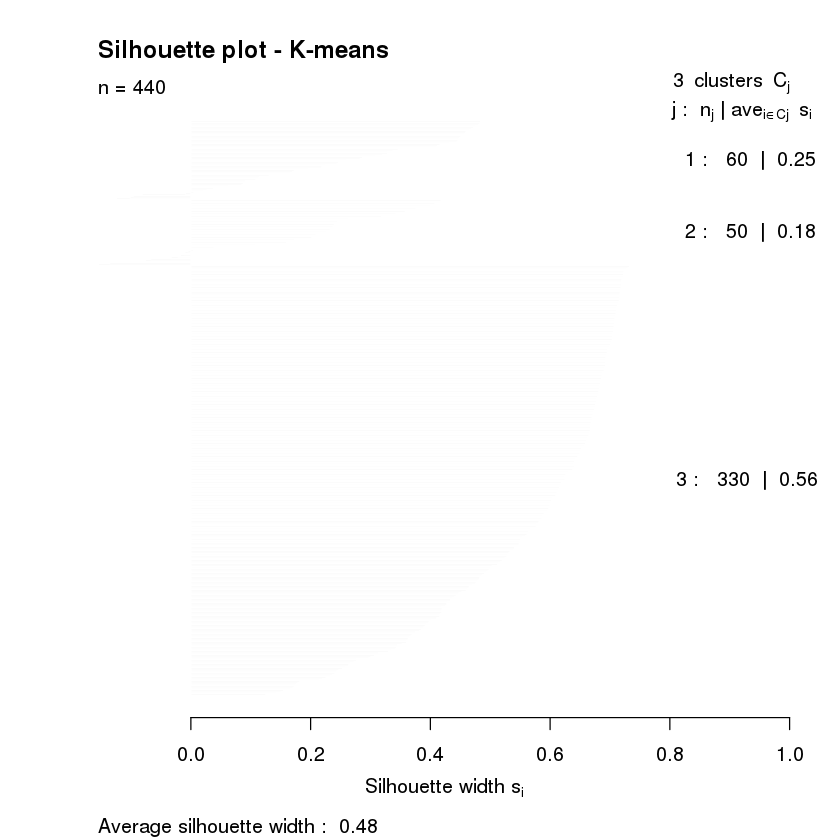

In [15]:
# Silhouette plot
plot(sil, main ="Silhouette plot - K-means")

  cluster size ave.sil.width
1       1   60          0.25
2       2   50          0.18
3       3  330          0.56


Warning message:
“Stacking not well defined when ymin != 0”

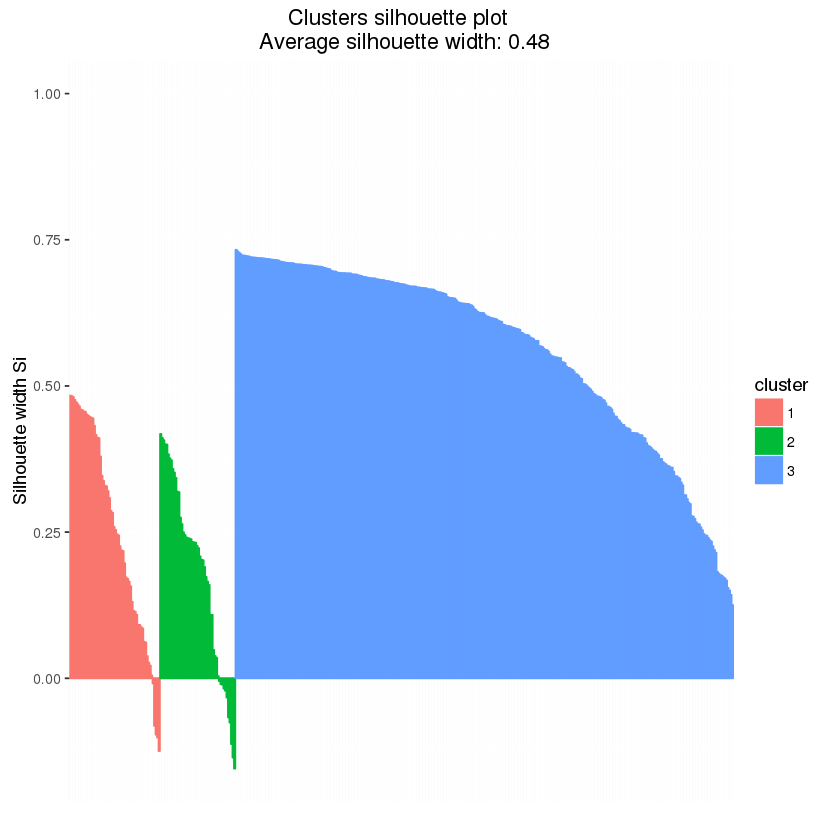

In [16]:
library(factoextra)
fviz_silhouette(sil)

The summary of the silhouette analysis can be computed using the function summary.silhouette() as follows.

In [17]:
# Summary of silhouette analysis
si.sum <- summary(sil)
# Average silhouette width of each cluster
si.sum$clus.avg.widths

1         2         3 
0.2524346 0.1800059 0.5646307

In [18]:
# The total average (mean of all individual silhouette widths)
si.sum$avg.width

[1] 0.4783511

In [19]:
# The size of each clusters
si.sum$clus.sizes

cl
  1   2   3 
 60  50 330 

##### Samples with a negative silhouette coefficient

In [20]:
# Silhouette widths of each observation
table(sil[, 1:3]<0)


FALSE  TRUE 
 1304    16 

There are quite a few samples that have a negative silhouette coefficient in kmeans clustering. This means that they are not in the right cluster.

We can find the name of these samples and determine the clusters they are closer (neighbor cluster), as follow:

In [21]:
# Objects with negative silhouette
neg_sil_index <- which(sil[, 'sil_width'] < 0)
sil[neg_sil_index, , drop = FALSE]

cluster,neighbor,sil_width
1,3,-0.101376491
2,3,-0.010088506
1,3,-0.081468382
2,3,-0.154445350
2,3,-0.017666916
2,3,-0.004800575
1,3,-0.096437827
1,3,-0.124450828
2,3,-0.075871944
2,3,-0.135694539


### 2. Dunn index

Dunn index is another internal clustering validation measure which can be computed as follows,

* For each cluster, compute the distance between each of the objects in the cluster and the objects in the other clusters
* Use the minimum of this pairwise distance as the inter-cluster separation (min.separation)
* For each cluster, compute the distance between the objects in the same cluster.
* Use the maximal intra-cluster distance (i.e maximum diameter) as the intra-cluster compactness
* Calculate Dunn index (D) as follow:

$$D=\frac{min.separation}{max.diameter}$$

The function cluster.stats() in fpc package and the NbClust() in NbClust package are used to compute Dunn index and many other indices. It returns a list containing many components useful for analyzing the intrinsic characteristics of a clustering:

* cluster.number: number of clusters
* cluster.size: vector containing the number of points in each cluster
* average.distance, median.distance: vector containing the cluster-wise within average/median distances
* average.between: average distance between clusters. We want it to be as large as possible
* average.within: average distance within clusters. We want it to be as small as possible
* clus.avg.silwidths: vector of cluster average silhouette widths. Recall that, the silhouette width is also an estimate of the * average distance between clusters. Its value is comprised between 1 and -1 with a value of 1 indicating a very good cluster.
* within.cluster.ss: a generalization of the within clusters sum of squares (k-means objective function), which is obtained if d is a Euclidean distance matrix.
* dunn, dunn2: Dunn index
* corrected.rand, vi: Two indexes to assess the similarity of two clustering: the corrected Rand index and Meila’s VI

In [22]:
library(fpc)
# Compute pairwise-distance matrices
dd <- dist(customers_scaled, method ="euclidean")
# Statistics for k-means clustering
km_stats <- cluster.stats(dd, km.res1$cluster)
# (k-means) within clusters sum of squares
km_stats$within.cluster.ss

[1] 80332413915

In [23]:
# (k-means) cluster average silhouette widths
km_stats$clus.avg.silwidths

1         2         3 
0.2524346 0.1800059 0.5646307

In [24]:
# Display all statistics
km_stats

$n
[1] 440

$cluster.number
[1] 3

$cluster.size
[1]  60  50 330

$min.cluster.size
[1] 50

$noisen
[1] 0

$diameter
[1] 96452.10 92496.02 42499.79

$average.distance
[1] 22505.73 25435.60 11849.05

$median.distance
[1] 16190.82 17214.20 11269.92

$separation
[1] 1631.438 3534.123 1631.438

$average.toother
[1] 33416.15 34637.56 31993.76

$separation.matrix
          [,1]      [,2]     [,3]
[1,]     0.000 10735.534 1631.438
[2,] 10735.534     0.000 3534.123
[3,]  1631.438  3534.123    0.000

$ave.between.matrix
         [,1]     [,2]     [,3]
[1,]     0.00 45991.18 31510.84
[2,] 45991.18     0.00 32573.27
[3,] 31510.84 32573.27     0.00

$average.between
[1] 33062.27

$average.within
[1] 12468.91

$n.between
[1] 39300

$n.within
[1] 57280

$max.diameter
[1] 96452.1

$min.separation
[1] 1631.438

$within.cluster.ss
[1] 80332413915

$clus.avg.silwidths
        1         2         3 
0.2524346 0.1800059 0.5646307 

$avg.silwidth
[1] 0.4783511

$g2
NULL

$g3
NULL

$pearsongamma
[1] 0.60104